In [3]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [4]:
data = pd.read_csv("data/walmart-triptype-train.csv.gz")
w_test_data = pd.read_csv("data/walmart-triptype-test.csv.gz")

## Exploring the Data

In [5]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [6]:
len(data[data.TripType == 8].VisitNumber.unique())

12161

TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category. <br>
VisitNumber - an id corresponding to a single trip by a single customer<br>
Weekday - the weekday of the trip<br>
Upc - the UPC number of the product purchased<br>
ScanCount - the number of the given item that was purchased. A negative value indicates a product return.<br>
DepartmentDescription - a high-level description of the item's department<br>
FinelineNumber - a more refined category for each of the products, created by Walmart<br>

In [7]:
data.count()

TripType                 647054
VisitNumber              647054
Weekday                  647054
Upc                      642925
ScanCount                647054
DepartmentDescription    645693
FinelineNumber           642925
dtype: int64

647,054 rows of this data. We can see that the only columns with missing data are: <br>
Upc (~4,000 missing values)<br>
Fineline Number (same number of missing values as Upc)<br>
Department Description (~1,500 missing values)<br>
<br>
Preliminary thoughts: <br>
4,000 rows represents a very small portion of the test data (0.6%), so I think it will be safe to simply remove any rows with missing data from our dataframe.


In [8]:
data.TripType.unique()

array([999,  30,  26,   8,  35,  41,  21,   6,  42,   7,   9,  39,  25,
        38,  15,  36,  20,  37,  32,  40,   5,   3,   4,  24,  33,  43,
        31,  27,  34,  18,  29,  44,  19,  23,  22,  28,  14,  12])

In [9]:
len(data.TripType.unique())

38

So, 38 unique Trip Types. We will need to understand what 999 represents (could be missing information. Would be interesting to do some preliminary visual exploration of this data

In [10]:
len(data.VisitNumber.unique())

95674

In [11]:
data.VisitNumber.max()

191347

In [12]:
data.VisitNumber.min()

5

The data contains 94,247 unique store trips, as each visit number is the ID for a trip, and will be repeated for every item that is purchased on that trip.

What do visit numbers represent?

In [13]:
data.Weekday.unique()

array(['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday'], dtype=object)

Nothing weird for days of the week, we should probably change them to numerals though. We can numerate Monday to Sunday as 1 to 7.

In [14]:
data.Upc.unique()

array([  6.81131529e+10,   6.05388160e+10,   7.41081110e+09, ...,
         8.85306278e+10,   8.87439527e+10,   5.44000008e+09])

In [15]:
data.Upc.min()

834.0

In [16]:
data.Upc.max()

978970666419.0

Good, no negative Upc numbers numbers

In [17]:
data.ScanCount.unique()

array([ -1,   1,   2,   3,   5,   6,   4,  14,  -2,   9,   7,  10,   8,
        -3,  -5,  11,  16,  -4,  13,  15,  30,  -6,  12,  20, -12,  19,
        46,  23,  -7,  22,  25,  24,  31,  -9,  51,  17,  18,  71, -10])

scan counts look clean, assuming negative values are for returns <br>
a max of 71 items seems outrageous though, want to make sure this outlier doesn't influence the analysis too much

In [18]:
data.DepartmentDescription.unique()

array(['FINANCIAL SERVICES', 'SHOES', 'PERSONAL CARE',
       'PAINT AND ACCESSORIES', 'DSD GROCERY', 'MEAT - FRESH & FROZEN',
       'DAIRY', 'PETS AND SUPPLIES', 'HOUSEHOLD CHEMICALS/SUPP', nan,
       'IMPULSE MERCHANDISE', 'PRODUCE', 'CANDY, TOBACCO, COOKIES',
       'GROCERY DRY GOODS', 'BOYS WEAR', 'FABRICS AND CRAFTS',
       'JEWELRY AND SUNGLASSES', 'MENSWEAR', 'ACCESSORIES',
       'HOME MANAGEMENT', 'FROZEN FOODS', 'SERVICE DELI',
       'INFANT CONSUMABLE HARDLINES', 'PRE PACKED DELI', 'COOK AND DINE',
       'PHARMACY OTC', 'LADIESWEAR', 'COMM BREAD', 'BAKERY',
       'HOUSEHOLD PAPER GOODS', 'CELEBRATION', 'HARDWARE', 'BEAUTY',
       'AUTOMOTIVE', 'BOOKS AND MAGAZINES', 'SEAFOOD', 'OFFICE SUPPLIES',
       'LAWN AND GARDEN', 'SHEER HOSIERY', 'WIRELESS', 'BEDDING',
       'BATH AND SHOWER', 'HORTICULTURE AND ACCESS', 'HOME DECOR', 'TOYS',
       'INFANT APPAREL', 'LADIES SOCKS', 'PLUS AND MATERNITY',
       'ELECTRONICS', 'GIRLS WEAR, 4-6X  AND 7-14', 'BRAS & SHAPEWEAR',


In [19]:
len(data.DepartmentDescription.unique())

68

DepartmentDescription look clean as well 

In [20]:
len(data.FinelineNumber.unique())

5196

In [21]:
data.FinelineNumber.max()

9998.0

In [22]:
data.FinelineNumber.min()

0.0

A fineline number of 0 sounds fishy, and it occurs over 3000 times.

In [23]:
data[data.FinelineNumber == 0].count()

TripType                 3837
VisitNumber              3837
Weekday                  3837
Upc                      3837
ScanCount                3837
DepartmentDescription    3837
FinelineNumber           3837
dtype: int64

In [24]:
fineline_is_zero = data[data.FinelineNumber == 0]

In [144]:
fineline_is_zero[fineline_is_zero.ScanCount == 1].count()  

TripType                 3743
VisitNumber              3743
Weekday                  3743
Upc                      3743
ScanCount                3743
DepartmentDescription    3743
FinelineNumber           3743
dtype: int64

In [25]:
fineline_is_zero[fineline_is_zero.ScanCount == -1].count()  

TripType                 53
VisitNumber              53
Weekday                  53
Upc                      53
ScanCount                53
DepartmentDescription    53
FinelineNumber           53
dtype: int64

Almost all the fineline = 0 occurences are when either 1 item was purchased or 1 item was returned. Not sure if this means anything because this could be consistent with the number of 1 or -1 occurrences anyway.

These are specific product categories created by Walmart, and there are 5,195 of them (wow). These should be modeled against the department categories above to better understand them. We should also analyze whether we will actually need this type of detail in our modeling. 

### Understanding the Fineline Numbers 

In [26]:
data_fineline_department = data[["DepartmentDescription", "FinelineNumber"]]

In [27]:
fineline_financial = data_fineline_department[data_fineline_department.DepartmentDescription == "FINANCIAL SERVICES"].FinelineNumber.value_counts()

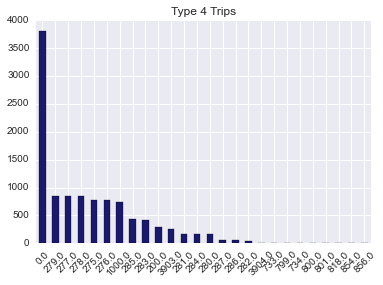

In [148]:
fineline_financial.plot(kind="bar", rot=45, title="Type 4 Trips", color="midnightblue")

## Cleaning Data

In [28]:
# Dropping rows with missing values

data = data.dropna()

In [29]:
data.count()

TripType                 642925
VisitNumber              642925
Weekday                  642925
Upc                      642925
ScanCount                642925
DepartmentDescription    642925
FinelineNumber           642925
dtype: int64

In [30]:
# Enumerate days of the week

data = data.replace("Monday", 1)
data = data.replace("Tuesday", 2)
data = data.replace("Wednesday", 3)
data = data.replace("Thursday", 4)
data = data.replace("Friday", 5)
data = data.replace("Saturday", 6)
data = data.replace("Sunday", 7)


In [31]:
data.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,5,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,5,6.053882e+10,1,SHOES,8931.0
2,30,7,5,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,5,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,5,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


I think we have a pretty clean data set to work with here. Thanks Walmart!

It would be a good idea to add a column identifying the number of items purchased on the trip! However, it will be tricky to do this within a datatable in which each item purchased is represented by a row 

Upc might not matter as much as the department description and number of items purchased<br><br>
Aggregate data could include columns for returns (yes/no), number of items purchased, but how would we not lose category? Could rank top five categories and list them (most frequent category, second most frequent, etc.)<br><br>
Right now, you couldn't classify any particular row as a triptype<br><br>
Need to do give each department description it's own column and provide a number purchased/returned


## Data Analysis

In [153]:
# lets explore the data through trip type

In [32]:
x = data.TripType.unique()
np.sort(x)

array([  3,   4,   5,   6,   7,   8,   9,  12,  14,  15,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44, 999])

In [33]:
data_triptypes = data.drop_duplicates("VisitNumber")

In [34]:
x = data_triptypes["TripType"]
x = x.value_counts()

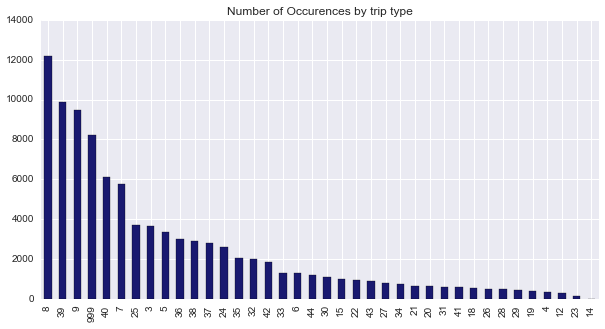

In [157]:
graph = x.plot(kind="bar", figsize=(10, 5), color="midnightblue")
graph.set_title("Number of Occurences by trip type")


Interesting - occurrences of different trip types are not evenly distributed. In fact, most trip types are categorized by just a handful of codes. 

Thinking about types of trips:<br>
- Types of items purchased<br>
- Weekday vs. weekend, or day of week<br>
- returns vs. purchasing

Takeaways from types of trips:<br>
    Many are focused on product category<br>
    The only confusing trips were revolving around groceries or included groceries<br>

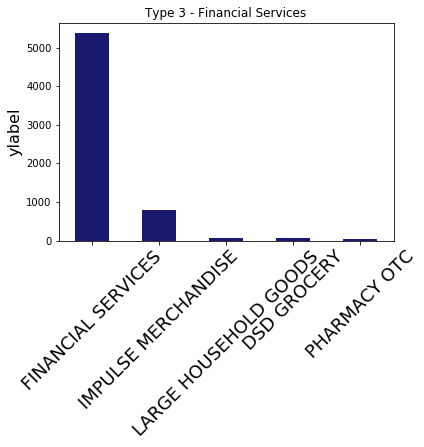

In [35]:
type_3 = data[data.TripType == 3]
type_3_items = type_3[["TripType","DepartmentDescription"]]
type_3_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                        title="Type 3 - Financial Services", color="midnightblue")
plt.xticks(fontsize=18)
plt.ylabel('ylabel', fontsize=16)


In [36]:
type_3_fineline = type_3.FinelineNumber.value_counts()
type_3_fineline_finance = type_3[type_3.DepartmentDescription == "FINANCIAL SERVICES"].FinelineNumber.value_counts()

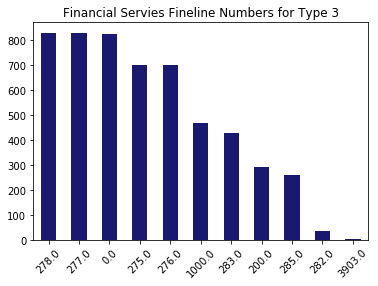

In [37]:
type_3_fineline_finance.plot(kind="bar", rot=45, title="Financial Servies Fineline Numbers for Type 3", color="midnightblue")

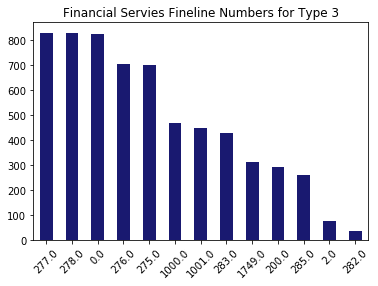

In [38]:
type_3_fineline.head(13).plot(kind="bar", rot=45, title="Financial Servies Fineline Numbers for Type 3", color="midnightblue")

It correlates as I suspected! The most frequent financial services fineline numbers - 

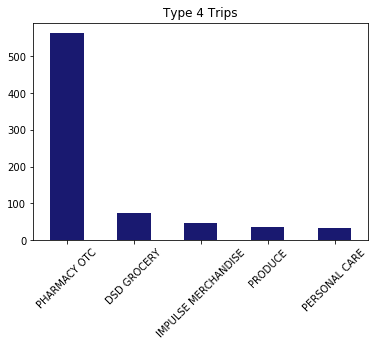

In [39]:
type_4 = data[data.TripType == 4]
type_4_items = type_4[["TripType","DepartmentDescription"]]
type_4_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, title="Type 4 Trips", color="midnightblue")

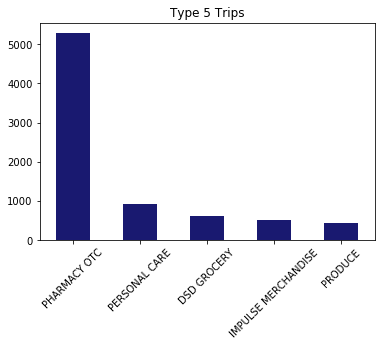

In [40]:
type_5 = data[data.TripType == 5]
type_5_items = type_5[["TripType","DepartmentDescription"]]
type_5_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 5 Trips", color="midnightblue")

type 5 trips = also pharmacy over the counter<br>
they must differ from type 4 trips by another metric, like day of week or number of purchases

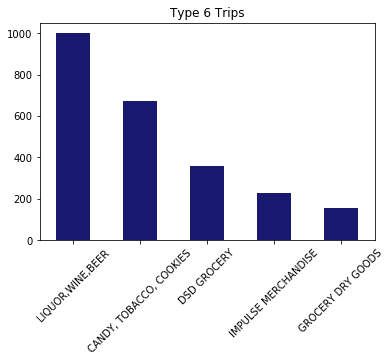

In [41]:
type_6 = data[data.TripType == 6]
type_6_items = type_6[["TripType","DepartmentDescription"]]
type_6_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 6 Trips", color="midnightblue")

Type 6 trips are about the booze. Alochol + candy/tobacco/cookies + grocery/impulse merchandise

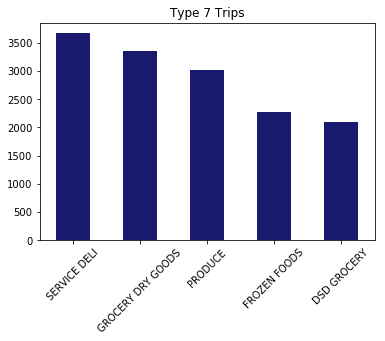

In [42]:
type_7 = data[data.TripType == 7]
type_7_items = type_7[["TripType","DepartmentDescription"]]
type_7_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 7 Trips", color="midnightblue")

Type 7 trips are clearly grocery runs

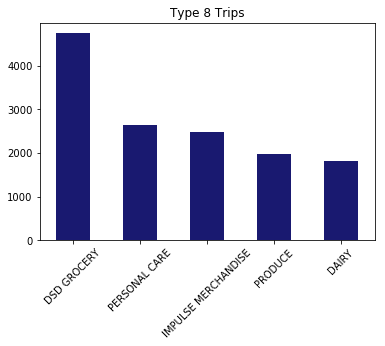

In [43]:
type_8 = data[data.TripType == 8]
type_8_items = type_8[["TripType","DepartmentDescription"]]
type_8_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 8 Trips", color="midnightblue")

Type 8 trips, the most frequent, seem like all purpose trips focused on grocery but also strong in personal care and impulse merchandise. They are not limited to grocery like type 7 trips and are twice as frequent. I wonder if the day, or number of items purchased, differs

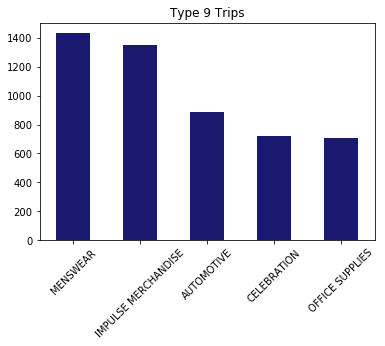

In [44]:
type_9 = data[data.TripType == 9]
type_9_items = type_9[["TripType","DepartmentDescription"]]
type_9_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 9 Trips", color="midnightblue")

All over the place here! Seems like this is a man shopping - men's clothing + automotive'

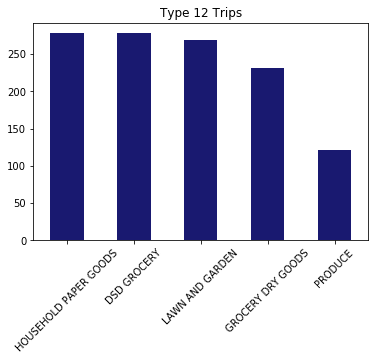

In [45]:
type_12 = data[data.TripType == 12]
type_12_items = type_12[["TripType","DepartmentDescription"]]
type_12_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 12 Trips", color="midnightblue")

All over the place again 

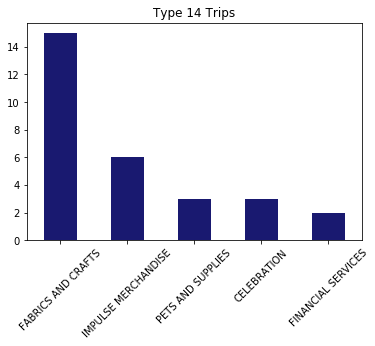

In [46]:
type_14 = data[data.TripType == 14]
type_14_items = type_14[["TripType","DepartmentDescription"]]
type_14_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 14 Trips", color="midnightblue")

fabrics and crafts trip - very infrequent - I call this the "Michael's" trip

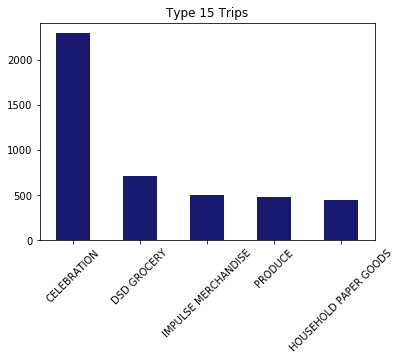

In [47]:
type_15 = data[data.TripType == 15]
type_15_items = type_15[["TripType","DepartmentDescription"]]
x = type_15_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 15 Trips", color="midnightblue")
#x.text(3,2000,"lalalala", size=15)

PARTY trips!

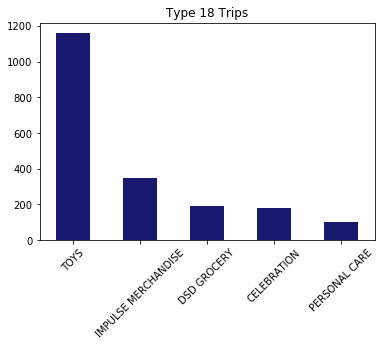

In [48]:
type_18 = data[data.TripType == 18]
type_18_items = type_18[["TripType","DepartmentDescription"]]
type_18_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 18 Trips", color="midnightblue")
plt.ylabel=('Items Purchased')

TOYS

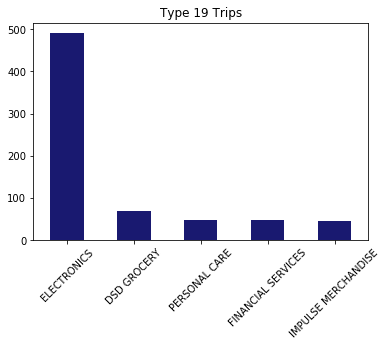

In [49]:
type_19 = data[data.TripType == 19]
type_19_items = type_19[["TripType","DepartmentDescription"]]
x = type_19_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 19 Trips", color="midnightblue")

Electronics

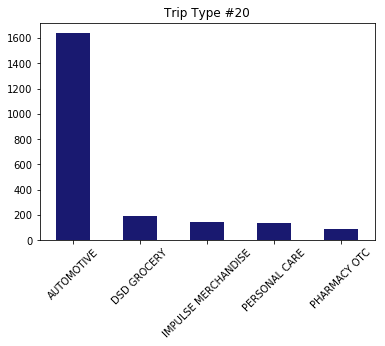

In [50]:
type_20 = data[data.TripType == 20]
type_20_items = type_20[["TripType","DepartmentDescription"]]
x = type_20_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Trip Type #20", color="midnightblue")


Automotive!

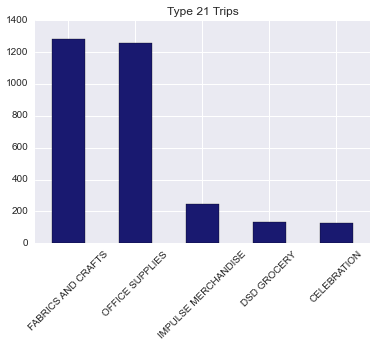

In [174]:
type_21 = data[data.TripType == 21]
type_21_items = type_21[["TripType","DepartmentDescription"]]
x = type_21_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 21 Trips", color="midnightblue")

Office supplies and fabrics/crafts - probably important which fabrics/crafts are being purchased

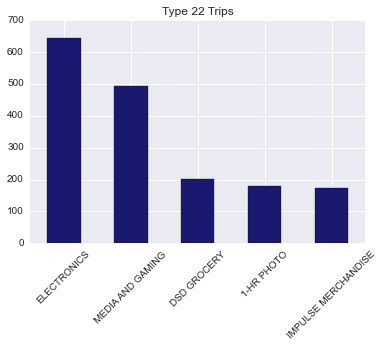

In [175]:
type_22 = data[data.TripType == 22]
type_22_items = type_22[["TripType","DepartmentDescription"]]
x = type_22_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 22 Trips", color="midnightblue")

Electronics + media and gaming -- probably different electronics than trip type 19, but that's the closest comparable

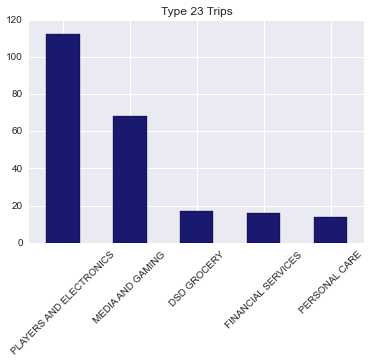

In [176]:
type_23 = data[data.TripType == 23]
type_23_items = type_23[["TripType","DepartmentDescription"]]
x = type_23_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 23 Trips", color="midnightblue")

players and electronics + media/gaming - how are players/electronics different than just electronics?

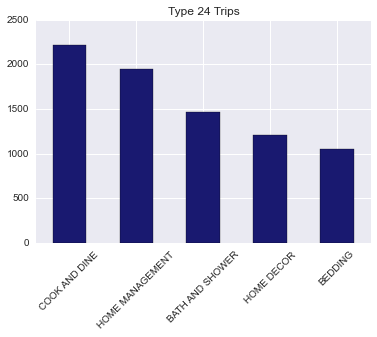

In [177]:
type_24 = data[data.TripType == 24]
type_24_items = type_24[["TripType","DepartmentDescription"]]
x = type_24_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 24 Trips", color="midnightblue")

Cook and dine - are these kitchen items? Looks like a best buy type trip

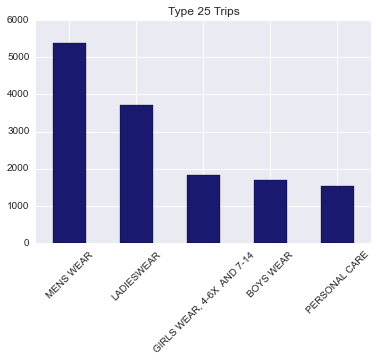

In [178]:
type_25 = data[data.TripType == 25]
type_25_items = type_25[["TripType","DepartmentDescription"]]
x = type_25_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 25 Trips", color="midnightblue")

Clothes trip, with more men's clothing being purchased

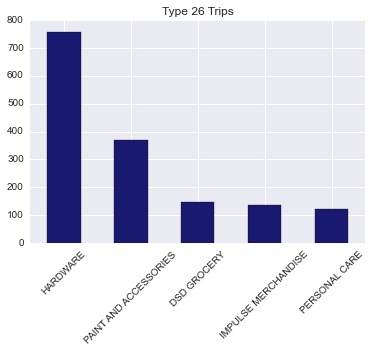

In [179]:
type_26 = data[data.TripType == 26]
type_26_items = type_26[["TripType","DepartmentDescription"]]
x = type_26_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 26 Trips", color="midnightblue")

hardware trip - home depot type trip

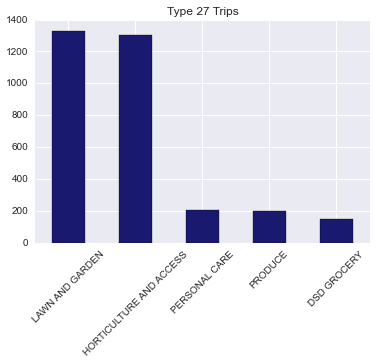

In [180]:
type_27 = data[data.TripType == 27]
type_27_items = type_27[["TripType","DepartmentDescription"]]
x = type_27_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 27 Trips", color="midnightblue")

lawn and garden + horticulture - home depot lawn and garden trip

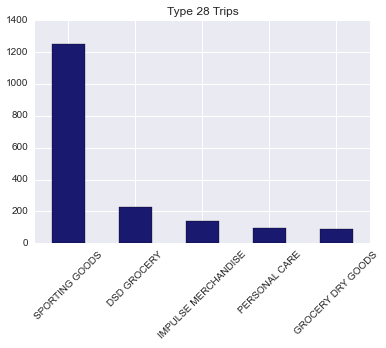

In [181]:
type_28 = data[data.TripType == 28]
type_28_items = type_28[["TripType","DepartmentDescription"]]
x = type_28_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 28 Trips", color="midnightblue")

The sporting goods trip!

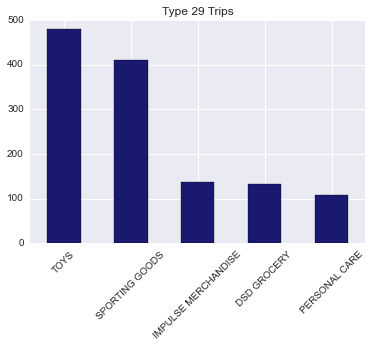

In [182]:
type_29 = data[data.TripType == 29]
type_29_items = type_29[["TripType","DepartmentDescription"]]
x = type_29_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 29 Trips", color="midnightblue")

Toys and sporting goods! Probably a kids trip, maybe focused on boys or a different age group?

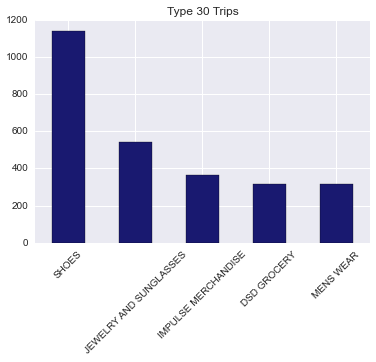

In [183]:
type_30 = data[data.TripType == 30]
type_30_items = type_30[["TripType","DepartmentDescription"]]
x = type_30_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 30 Trips", color="midnightblue")

Shoe and jewelry

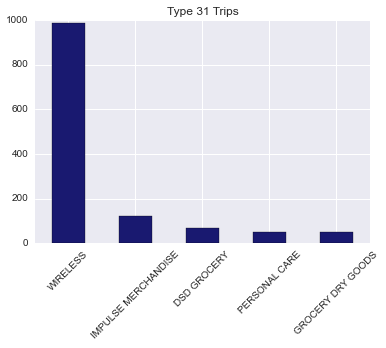

In [184]:
type_31 = data[data.TripType == 31]
type_31_items = type_31[["TripType","DepartmentDescription"]]
x = type_31_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 31 Trips", color="midnightblue")

Wireless technology (cellphones?)

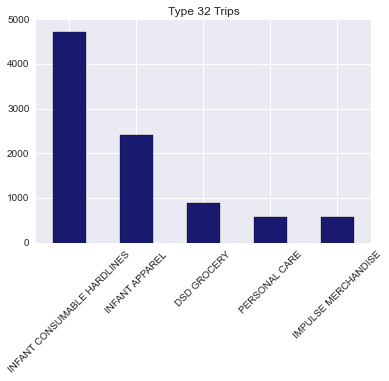

In [185]:
type_32 = data[data.TripType == 32]
type_32_items = type_32[["TripType","DepartmentDescription"]]
x = type_32_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 32 Trips", color="midnightblue")

Baby products 

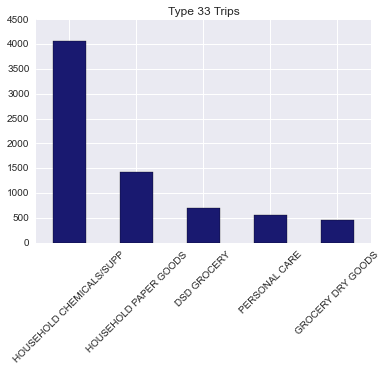

In [186]:
type_33 = data[data.TripType == 33]
type_33_items = type_33[["TripType","DepartmentDescription"]]
x = type_33_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 33 Trips", color="midnightblue")

household chemical supplies + paper goods

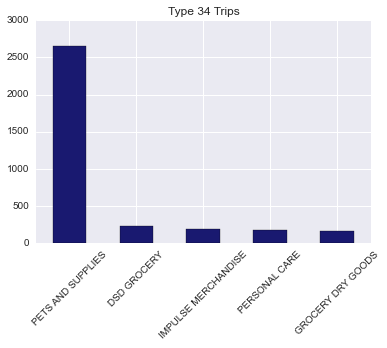

In [187]:
type_34 = data[data.TripType == 34]
type_34_items = type_34[["TripType","DepartmentDescription"]]
x = type_34_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 34 Trips", color="midnightblue")

Pet trip!

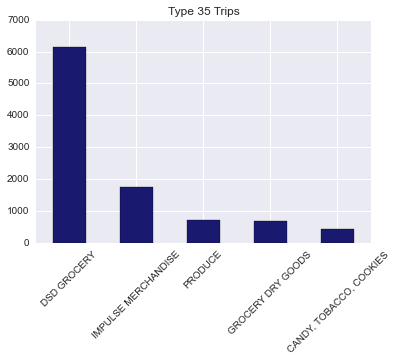

In [188]:
type_35 = data[data.TripType == 35]
type_35_items = type_35[["TripType","DepartmentDescription"]]
x = type_35_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 35 Trips", color="midnightblue")

DSD Groceries (Direct store deliery) - focus on brands?

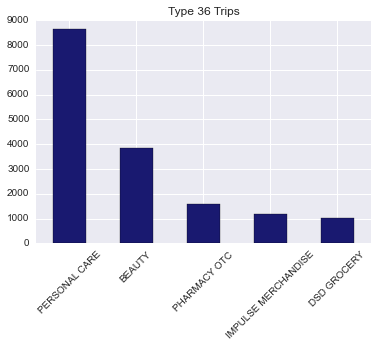

In [189]:
type_36 = data[data.TripType == 36]
type_36_items = type_36[["TripType","DepartmentDescription"]]
x = type_36_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 36 Trips", color="midnightblue")

personal care + beauty

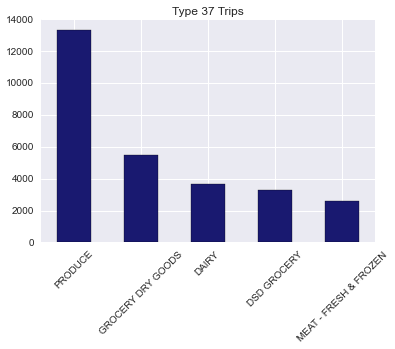

In [190]:
type_37 = data[data.TripType == 37]
type_37_items = type_37[["TripType","DepartmentDescription"]]
x = type_37_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 37 Trips", color="midnightblue")

Produce trips - another type of grocery trip

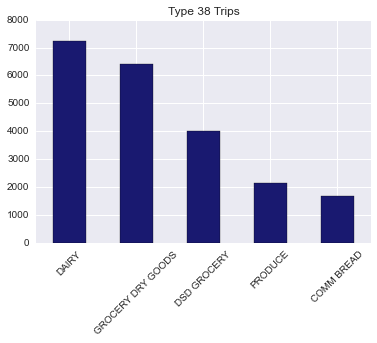

In [191]:
type_38 = data[data.TripType == 38]
type_38_items = type_38[["TripType","DepartmentDescription"]]
x = type_38_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 38 Trips", color="midnightblue")

Another grocery trip, with a focus on dairy (probably milk)

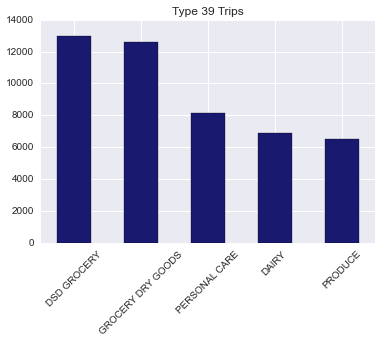

In [192]:
type_39 = data[data.TripType == 39]
type_39_items = type_39[["TripType","DepartmentDescription"]]
x = type_39_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 39 Trips", color="midnightblue")

Another grocery trip 

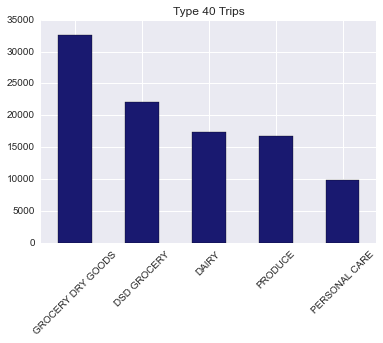

In [193]:
type_40 = data[data.TripType == 40]
type_40_items = type_40[["TripType","DepartmentDescription"]]
x = type_40_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 40 Trips", color="midnightblue")

Another grocery trip 

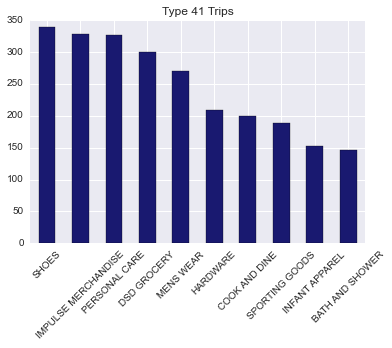

In [194]:
type_41 = data[data.TripType == 41]
type_41_items = type_41[["TripType","DepartmentDescription"]]
x = type_41_items.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=45, 
                                                              title="Type 41 Trips", color="midnightblue")

A mix - could this be a return trip? Also, not very frequent

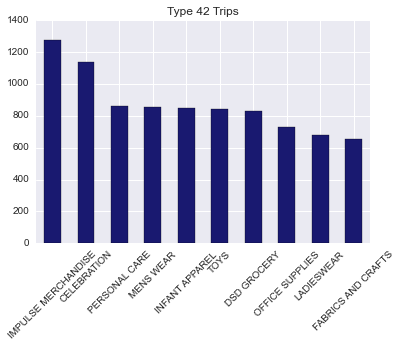

In [195]:
type_42 = data[data.TripType == 42]
type_42_items = type_42[["TripType","DepartmentDescription"]]
x = type_42_items.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=45, 
                                                              title="Type 42 Trips", color="midnightblue")

Another mix

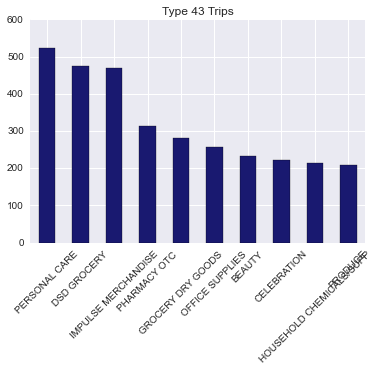

In [196]:
type_43 = data[data.TripType == 43]
type_43_items = type_43[["TripType","DepartmentDescription"]]
x = type_43_items.DepartmentDescription.value_counts().head(10).plot(kind="bar", rot=45, 
                                                              title="Type 43 Trips", color="midnightblue")

Another mix

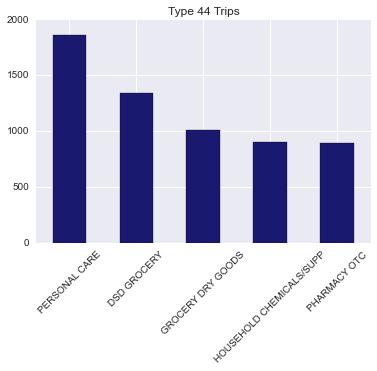

In [197]:
type_44 = data[data.TripType == 44]
type_44_items = type_44[["TripType","DepartmentDescription"]]
x = type_44_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 44 Trips", color="midnightblue")

mix of typical stuff

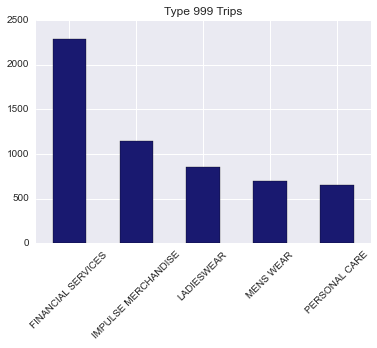

In [198]:
type_999 = data[data.TripType == 999]
type_999_items = type_999[["TripType","DepartmentDescription"]]
x = type_999_items.DepartmentDescription.value_counts().head().plot(kind="bar", rot=45, 
                                                              title="Type 999 Trips", color="midnightblue")

"Others" are often financial services related